In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from brian2 import *

from utils.equations import (
    dndt,
)
from utils.funcs import (
    basic_namespace,
    plot_v_by_equation,
    compIFcurve,
    compIFcurve_by_equation,
    plotIFcurve
)


prefs.codegen.target = 'numpy'

In [16]:
basic_I = Equations("""
INa = gNa*m**3*h*(Ena-v) : amp
IK = gK*n**4*(Ek-v) : amp
I : amp
""")
base_master_eq = Equations("""
dv/dt = (gL * (El - v) + IK + INa + I) / Cm : volt""")
dmdt = Equations(
"""
dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32*4*0.8 / exprel((13*mV - v + VT + 3*mV)/4/mV) / ms : Hz
b_m = 0.28 * 5 / exprel((v - VT - 40*mV + 3*mV)/5/mV) / ms : Hz
"""
)
dhdt = Equations(
"""
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*0.2*exp((17*mV - v + VT + 15*mV)/18/mV) / ms : Hz
b_h = 4*0.2 / (1 + exp((40*mV - v + VT + 15*mV)/5/mV)) / ms : Hz
"""
)
h_s = Equations(
"""
alpha_h = 0.002 * exp(-(v/mV + 20)/30) / ms : Hz
beta_h = 0.1 / (1 + 0.2 * exp(-(v/mV + 30)/7)) / ms : Hz
h_inf = alpha_h / (alpha_h + beta_h) : 1
tau_h = 1 / (alpha_h + beta_h) : second
dh/dt = (h_inf - h) / tau_h : 1
""",
    h="h_s", h_inf="h_s_inf", tau_h="tau_h_s",
    alpha_h="alpha_h_s", beta_h="beta_h_s",
)
m_s = Equations(
"""
alpha_m = exp(0.039/mV * (v + 20*mV) - 0.56) / ms : Hz
beta_m = exp(-0.049/mV * (v + 20*mV) + 2.53) / ms : Hz
m_inf = alpha_m / (alpha_m + beta_m) : 1
tau_m = 1 / (alpha_m + beta_m) : second
""",
    m="m_s", m_inf="m_s_inf", tau_m="tau_m_s",
    alpha_m="alpha_m_s", beta_m="beta_m_s",
)
Knav_master_eq = Equations(
    """
dv/dt = (gL * (El - v) + IK + INa + INav18 + I) / Cm : volt
INav18 = gNa18 * m_s**3 * h_s * (Ena - v) : amp
"""
)
base_eq = base_master_eq + basic_I + dndt + dhdt + dmdt
Knav_eq = Knav_master_eq + basic_I + dndt + dhdt + dmdt + m_s + h_s


In [17]:
test_namespace = basic_namespace.copy()
test_namespace.update(
    {"gNa": 25*nS, "gNa18": 75*nS, "gL": 1*nS,}
)
baseifmon, baseifgroup = compIFcurve_by_equation(base_eq,
                                                 test_namespace,
                                                 max_cur=150, N=50)
knavifmon, knavifgroup = compIFcurve_by_equation(Knav_eq,
                                                 test_namespace,
                                                 max_cur=150, N=50)

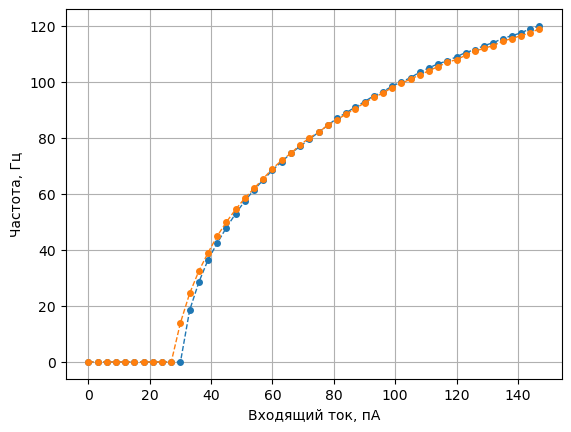

In [19]:
plotIFcurve(baseifmon, baseifgroup)
plotIFcurve(knavifmon, knavifgroup)